<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./322_Californian_fires_summer_2020_case_study.ipynb"><< 322 - Case study - Californian fires - Summer 2020</a><span style="float:right;"><a href="./332_Sentinel-3_SLSTR_NRT_FRP_Californian_fires_case_study.ipynb">332 - Case study - Sentinel-3 SLSTR NRT FRP - Californian fires >></a></span>

<div class="alert alert-block alert-warning">
<b>30 - CASE STUDIES</b></div>

<div class="alert alert-block alert-warning">

<b>PREREQUISITES </b>

The following **20 - DATA DISCOVERY** module is a prerequisite:   
- [252 - Sentinel-3 SLSTR NRT - Fire Radiative Power - Load and browse](../20_data_discovery/252_Sentinel-3_SLSTR_NRT_FRP_load_browse.ipynb)

It is recommended to go through the module before you start with this module.
</div>

<hr>

# 3.3.1 Sentinel-3 SLSTR Near-Real-Time Fire Radiative Power (FRP)

###  Example Chernobyl Fires - May 2020

The [Copernicus Near-Real-Time (NRT) Sentinel-3 SLSTR Fire Radiative Power (FRP)](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) product identifies the location, and quantifies the radiative power, of any hotspot present on land and ocean Earth surfaces, that radiates a heating signal within a pixel size of 1 km<sup>2</sup>.

All threatening hotspots are identified and characterised within three hours from SLSTR observation sensing time.
The current version of the NRT S3 FRP processor is mainly applicable during the night while only a few daytime granules, with non-saturated background (i.e. no fires) radiance, are processed at this stage. The NRT S3 FRP product will become operational after a higher level of quality and maturity is reached, including the full processing of granules during daytime, a comprehensive global validation, and positive feedback by experts and users.

Get more product specifications [here](https://www.eumetsat.int/website/home/News/DAT_4962463.html).

The following workflow is based on an example of `Sentinel-3 Near Real Time SLSTR FRP` data on 7 May 2020 capturing the fires in Chernobyl, Ukraine.

#### This module has the following outline:
* [1 - Load Sentinel-3 SLSTR NRT FRP data](#load_s3_frp)
* [2 - Load, mask and regrid NRT FRP computed from MWIR channel (3.7 um)](#load_mwir)
* [3 - Load, mask and regrid NRT FRP computed from SWIR channel (2.25 um)](#load_swir)
* [4 - Load, mask and regrid NRT FRP computed from SWIR channel (2.25 um) with SAA filter applied](#load_swir_nosaa)

#### Load required libraries

In [1]:
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as pltfacebook
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='load_s3_frp'></a>Load Sentinel-3 SLSTR NRT FRP data

Sentinel-3 SLSTR NRT FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `open_dataset` function.


Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are three variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW] - to detect fires with temperatures less than 1000 Kelvin
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW] - to detect fires with temperatures above 1000 Kelvin
- `FLAG_SWIR_SAA` - Flag values to filter out South Atlantic ANomalies (SAA) & other transient / spurious events, only applicable to FRP SWIR

In [4]:
frp_dir = '../eodata/sentinel3/slstr/2020/05/07/'
frp_xr = xr.open_dataset(frp_dir+'FRP_in_Chernobyl_202000507.nc')
frp_xr

<xarray.Dataset>
Dimensions:                 (columns: 1500, fires: 917, rows: 2052)
Dimensions without coordinates: columns, fires, rows
Data variables:
    i                       (fires) int16 ...
    j                       (fires) int32 ...
    time                    (fires) datetime64[ns] ...
    latitude                (fires) float64 ...
    longitude               (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    transmittance_MWIR      (fires) float64 ...
    FRP_SWIR                (fires) float64 ...
    FRP_uncertainty_SWIR    (fires) float64 ...
    FLAG_SWIR_SAA           (fires) int16 ...
    transmittance_SWIR      (fires) float64 ...
    confidence              (fires) float64 ...
    classification          (fires) uint8 ...
    S7_Fire_pixel_radiance  (fires) float32 ...
    F1_Fire_pixel_radiance  (fires) float32 ...
    used_channel            (fires) uint8 ...
    Radiance_window         (fires) float32 ...
    Glint_angle             (fires) float64 ...
    IFOV_area               (fires) float64 ...
    TCWV                    (fires) float64 ...
    n_window                (fires) int16 ...
    n_water                 (fires) int16 ...
    n_cloud                 (fires) int16 ...
    n_SWIR_fire             (fires) float32 ...
    flags                   (rows, columns) uint32 ...
Attributes:
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20200416T190433_20200416T190941_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 02.00
    history:                 
    references:             S3MPC ACR FRP 003 - i1r2 - SLSTR L2 Product Data ...
    contact:                ops@eumetsat.int
    creation_time:          2020-04-16T21:53:43Z
    resolution:             [ 1000 1000 ]
    absolute_orbit_number:  21689
    start_time:             2020-04-16T19:04:32.911768Z
    stop_time:              2020-04-16T19:09:40.697645Z
    track_offset:           998
    start_offset:           5589

#### Load `latitude` and `longitude` information

You can already load the `latitude` and `longitude` information, which will be required for the regridding process.

In [5]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lon_frp

<xarray.DataArray 'longitude' (fires: 917)>
array([30.624516, 30.621522, 33.699894, ..., 27.320211, 27.359079, 27.313064])
Dimensions without coordinates: fires
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    valid_min:      -180.0
    valid_max:      180.0

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [6]:
sampling_lat_FRP_grid = 0.25        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.25        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots


lat_min               = 33.        # Minimum latitude for mapping plot [deg N]
lat_max               = 55.        # Maximum latitude for mapping plot [deg N]
lon_min               = 15.        # Minimum lonitude for mapping plot [deg E]
lon_max               = 45.        # Maximum lonitude for mapping plot [deg E]

Now, let us go through the three different variables (`MWIR`, `SWIR` and `SWIR with SAA filtered out`) and let us load, mask, regrid and visualize them.

## <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You, see that the variable contains 917 fire entries in total.

In [7]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 917)>
array([ 6.167   ,  3.367636, 11.410757, ...,  1.367898, 11.605793,  2.245801])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

The next step is to extract (mask) FRP pixels with no signal. Valid pixels are different to -1. You can use the function [generate_masked_array](../functions.ipynb#generate_masked_array) to extract the right pixels. You see that 855 fire were detected from the MWIR channels (S7 and F1).

In [8]:
masked_frp_mwir = generate_masked_array(xarray=frp_mwir, 
                                        mask=frp_mwir, 
                                        threshold=-1.,
                                        operator='!=',
                                        drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 855)>
array([6.16699951e+00, 3.36763645e+00, 1.14107566e+01, 4.45424465e+00,
       4.27386557e+00, 5.21323781e+00, 1.70488541e+00, 3.41268984e+00,
       1.53749489e+00, 1.81332422e+00, 4.23288345e+00, 3.69155068e+00,
       1.09806917e+00, 1.78122927e+00, 2.09246559e+00, 1.20881606e+00,
       3.11088384e+00, 1.46939988e+00, 5.54475038e+00, 1.97330746e+00,
       1.80441982e+00, 1.63266950e+00, 3.79837237e+00, 2.76260768e+00,
       1.16370989e+00, 1.04846956e+01, 1.11645894e+00, 1.22250291e+01,
       1.76294248e+00, 2.01682839e+01, 1.89951220e+01, 6.17491045e+00,
       1.61734593e+00, 2.43567966e+01, 2.42422313e+00, 3.72179188e+00,
       5.62023745e+00, 2.18434213e+00, 4.76012987e+00, 1.09398375e+01,
       1.42717564e+01, 1.91653460e+00, 1.33474336e+01, 5.88623730e+00,
       4.68651351e+00, 5.82744740e+00, 4.82752620e+00, 1.78634387e+00,
       5.61009343e+00, 2.49968496e+00, 2.34033250e+00, 2.83751966e+00,
       8.41279864e+00, 3.51317352e+00, 1.83926592e+00, 7.00122533e+00,
       2.82462352e+00, 3.55449381e+00, 1.44636406e+00, 2.93519066e+00,
       2.75651868e+00, 7.86092962e+00, 2.35380650e+00, 1.49006774e+00,
       1.74477525e+00, 9.95750052e+00, 3.72367899e+00, 4.31420569e+00,
       2.58087255e+00, 8.96117213e+00, 1.00865491e+01, 2.37876151e+00,
       3.69815298e+00, 1.82725861e+00, 2.06980691e+00, 3.04829477e+00,
       2.10387854e+00, 4.00983804e+01, 3.48005962e+00, 4.00798280e+01,
...
       2.86093073e+00, 3.94660140e+00, 3.98595753e+00, 2.10919612e+00,
       3.11680594e+00, 8.13230807e-01, 1.25450363e+00, 8.58742854e-01,
       1.79124931e+00, 1.60840344e+00, 8.57261664e-01, 1.61797612e+00,
       1.61800425e+00, 2.60114775e+00, 2.57728293e+00, 2.57937185e+00,
       1.41956388e+00, 1.98577456e+00, 1.98740545e+00, 2.12216976e+00,
       1.23927874e+00, 9.36951922e-01, 9.27496103e-01, 2.00160389e+00,
       1.86367381e+00, 1.28576678e+00, 2.12168852e+00, 2.07986768e+00,
       1.15608588e+00, 1.15703933e+00, 2.04121289e+00, 1.15235627e+00,
       6.33688990e-01, 1.10530255e+00, 2.09732107e+00, 2.17206922e+00,
       1.63260520e+00, 5.42331109e-01, 1.65302731e+00, 3.16595583e+00,
       1.37617650e+00, 1.34555853e+00, 1.21656585e+01, 2.93336310e+00,
       8.57362593e-01, 3.71612657e+00, 1.41477410e+00, 2.66295146e+00,
       2.64288339e+00, 2.60819767e+00, 1.26621020e+00, 4.98439632e+00,
       3.14890812e+00, 3.27099315e+00, 2.79445227e+00, 3.98744682e+00,
       3.70065816e+00, 7.08983402e+00, 1.81360350e+00, 6.00135131e+00,
       2.04564685e+00, 7.07672178e-01, 1.96178767e+00, 7.12554165e+00,
       1.60541557e+00, 4.05240655e+00, 7.66208402e-01, 6.01823431e-01,
       1.28806051e+00, 8.90157493e-01, 1.11834814e+00, 3.27215394e+00,
       7.57218126e+00, 1.97044262e+00, 6.26848016e-01, 1.18015271e+00,
       1.36789751e+00, 1.16057926e+01, 2.24580122e+00])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

Let us store the number of hotspots / fires in total and per category as variables.

In [9]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(917, 855)

### Generate a gridded FRP array

Let us compute the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
Apply the function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) to the `frp_mwir` data array.

In [10]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_mwir, 
                                                       parameter='mwir', 
                                                       lat_min=lat_min, 
                                                       lat_max=lat_max, 
                                                       lon_min=lon_min, 
                                                       lon_max=lon_max, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_MWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)
FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[33.125, 33.125, 33.125, ..., 33.125, 33.125, 33.125],
        [33.375, 33.375, 33.375, ..., 33.375, 33.375, 33.375],
        [33.625, 33.625, 33.625, ..., 33.625, 33.625, 33.625],
        ...,
        [54.625, 54.625, 54.625, ..., 54.625, 54.625, 54.625],
        [54.875, 54.875, 54.875, ..., 54.875, 54.875, 54.875],
        [55.125, 55.125, 55.125, ..., 55.125, 55.125, 55.125]],
       dtype=float32),
 array([[15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625

Mask out the invalid pixels for plotting. You can use numpy's function `np.ma.masked_array()` for this.

In [11]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir          = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Calculate some statistics, such as mean, std, min and max, and add them to a string that can be integrated in the final plot.

In [12]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



### Visualize the masked data array with the function `visualize_s3_frp`

Now, you can apply the function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) and plot the `FRP computed from MWIR channel` data. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

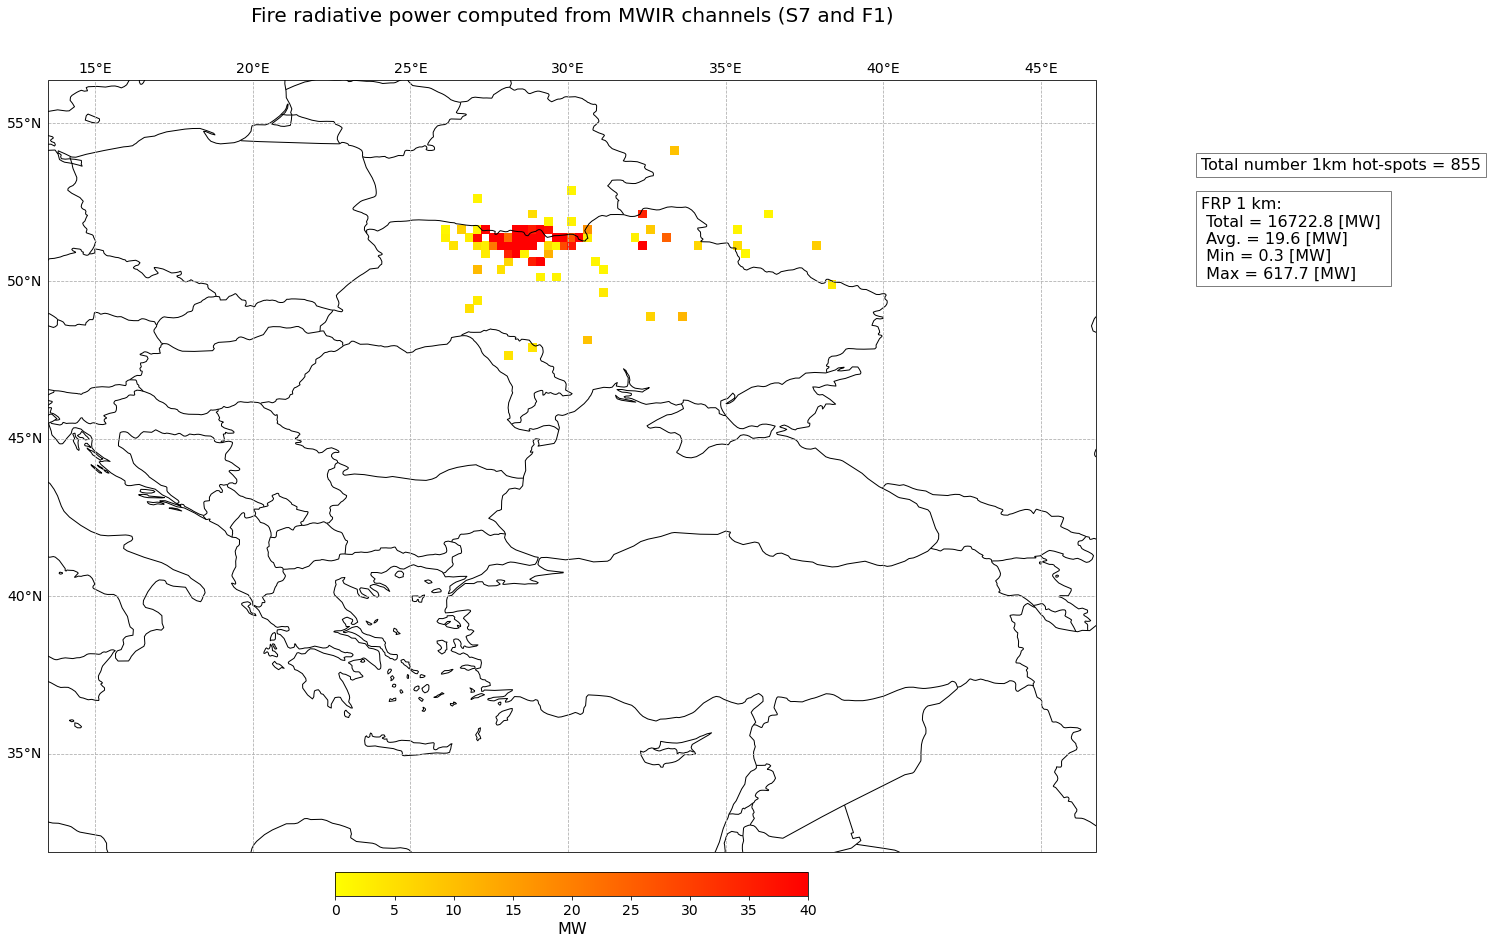

In [13]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_mwir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name, 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<br>

Let us now repeat the processing steps above and let us process and visualize the `FRP computed from the SWIR channel`.

## <a id='load_swir'></a>Load, mask and regrid `FRP computed from SWIR channel (2.25 um)`

Load the `FRP_SWIR` data variable from the loaded `netCDF` file.

In [14]:
frp_swir = frp_xr['FRP_SWIR']
frp_swir

<xarray.DataArray 'FRP_SWIR' (fires: 917)>
array([-1., -1., -1., ..., -1., -1., -1.])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

Filter only valid pixels and filter all pixels with -1 out. You see that out of the 917 total fires detected, only 288 fires were detected by the SWIR channel (S6).

In [16]:
masked_frp_swir = generate_masked_array(xarray=frp_swir, 
                                        mask=frp_swir, 
                                        threshold=-1., 
                                        operator='!=', 
                                        drop=True)
masked_frp_swir

<xarray.DataArray 'FRP_SWIR' (fires: 288)>
array([  1.78237245,  14.49562811,   3.33291371,   2.14934458,
         2.56304328,   3.90616017,  25.01275899,   3.29803704,
         2.18113198,  10.08653529,   4.08239337,   4.14176581,
        17.53911234,  24.31956132,  39.66215248,  33.82620415,
        30.35514323,  16.5899628 ,  10.69805581,  16.46655874,
         8.61558456,  12.39634869,  15.37661605,   2.09217688,
         5.39678422,   9.31182407,   5.53583791,   4.73188584,
         2.24392179,   4.82475667,   2.02795424,  10.90125825,
        42.19268652,  78.43669098,   5.26424931,   6.44829128,
         4.02902254,   4.40256972, 114.4474222 ,  14.36229928,
         4.00833544,   2.1363703 ,  63.64643835,  40.05282978,
         4.82775712,   4.93608558,   7.24567586,   9.50146626,
         2.60117086,   4.69945244,  22.84236851,   5.26941898,
         3.54188678,   3.83032744,  17.2442377 ,   5.01388154,
         3.33508042,   3.35060416,   3.05037712,  98.84662998,
        28.48529574,  97.98744278,  12.09501137,   6.53972056,
        16.7393141 ,   5.95320505,  96.66842125, 145.75499258,
        85.90668195,  58.88739258,  30.70970452,  12.04985274,
         2.99779824, 146.44188578,  36.4594933 ,  14.35096281,
        21.78522798,  26.85353738,  34.81490182,  18.12812372,
...
         4.80446191,  11.62447116,  12.47087527,   2.78774938,
        12.34110274,  14.70438707,   9.69523975,  11.95392955,
         2.62882864,   2.6944352 ,   2.83754263,   3.84452064,
         9.37167223,   2.5706428 ,   4.11995493,  42.59326735,
         7.20035676,   5.78504398,   5.79775833,   4.92857802,
         8.42913429,   2.28509322,   2.19690111,   2.17780918,
        10.21241492,  40.94081832,   4.77733552,   4.88029332,
         2.13564605,   2.91995814,  12.86637011,  25.16388654,
         3.08774416,   4.15847944,  15.66028289,  60.99995361,
        15.4219094 ,   3.44949106,   3.54539624,  27.82770275,
         7.11206998,   3.23168261,  11.46899361,  36.99868431,
         2.29013721,   4.42277682,   2.28085854,   5.55289922,
         2.25381566,  22.3870707 ,  39.84480084,   2.06024876,
         4.73529141,  19.61034024,   3.29988249,   6.30838584,
         3.64944583,   2.44370361,  26.30880727,   9.21348207,
         3.1587122 ,  20.1291376 ,  30.39497223,   4.2724718 ,
         3.83997233,  48.12237184,   2.67097676,   2.44301919,
         4.67715784,   4.64287519,   3.57717673,   7.57797711,
         6.78176743,   2.2826038 ,   2.37895625,  21.47653022,
         0.94181274,   1.86501398,   4.55366927,   0.78568795])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

Store the number of total fires and per category as variables.

In [17]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR          = len(masked_frp_swir.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR

(917, 288)

Apply the gridding function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) and grid the `FRP computed from the SWIR channel`.

In [18]:
FRP_SWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_swir, 
                                                       parameter='swir', 
                                                       lat_min=lat_min, 
                                                       lat_max=lat_max, 
                                                       lon_min=lon_min, 
                                                       lon_max=lon_max, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_SWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)

FRP_SWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[33.125, 33.125, 33.125, ..., 33.125, 33.125, 33.125],
        [33.375, 33.375, 33.375, ..., 33.375, 33.375, 33.375],
        [33.625, 33.625, 33.625, ..., 33.625, 33.625, 33.625],
        ...,
        [54.625, 54.625, 54.625, ..., 54.625, 54.625, 54.625],
        [54.875, 54.875, 54.875, ..., 54.875, 54.875, 54.875],
        [55.125, 55.125, 55.125, ..., 55.125, 55.125, 55.125]],
       dtype=float32),
 array([[15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625

Mask out all invalid pixels for plotting.

In [19]:
mask_valid = np.where(FRP_SWIR_grid[:,:] != -9999., False, True)
D_swir          = np.ma.masked_array(FRP_SWIR_grid[:,:], mask=mask_valid)

Calculate some statistics, such as mean, max, min and std, and add them to a string that can be integrated in the final plot.

In [20]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR)


FRP_sum      = np.sum(masked_frp_swir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



Apply the plotting function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) and take some attributes from the data variable's attributes.

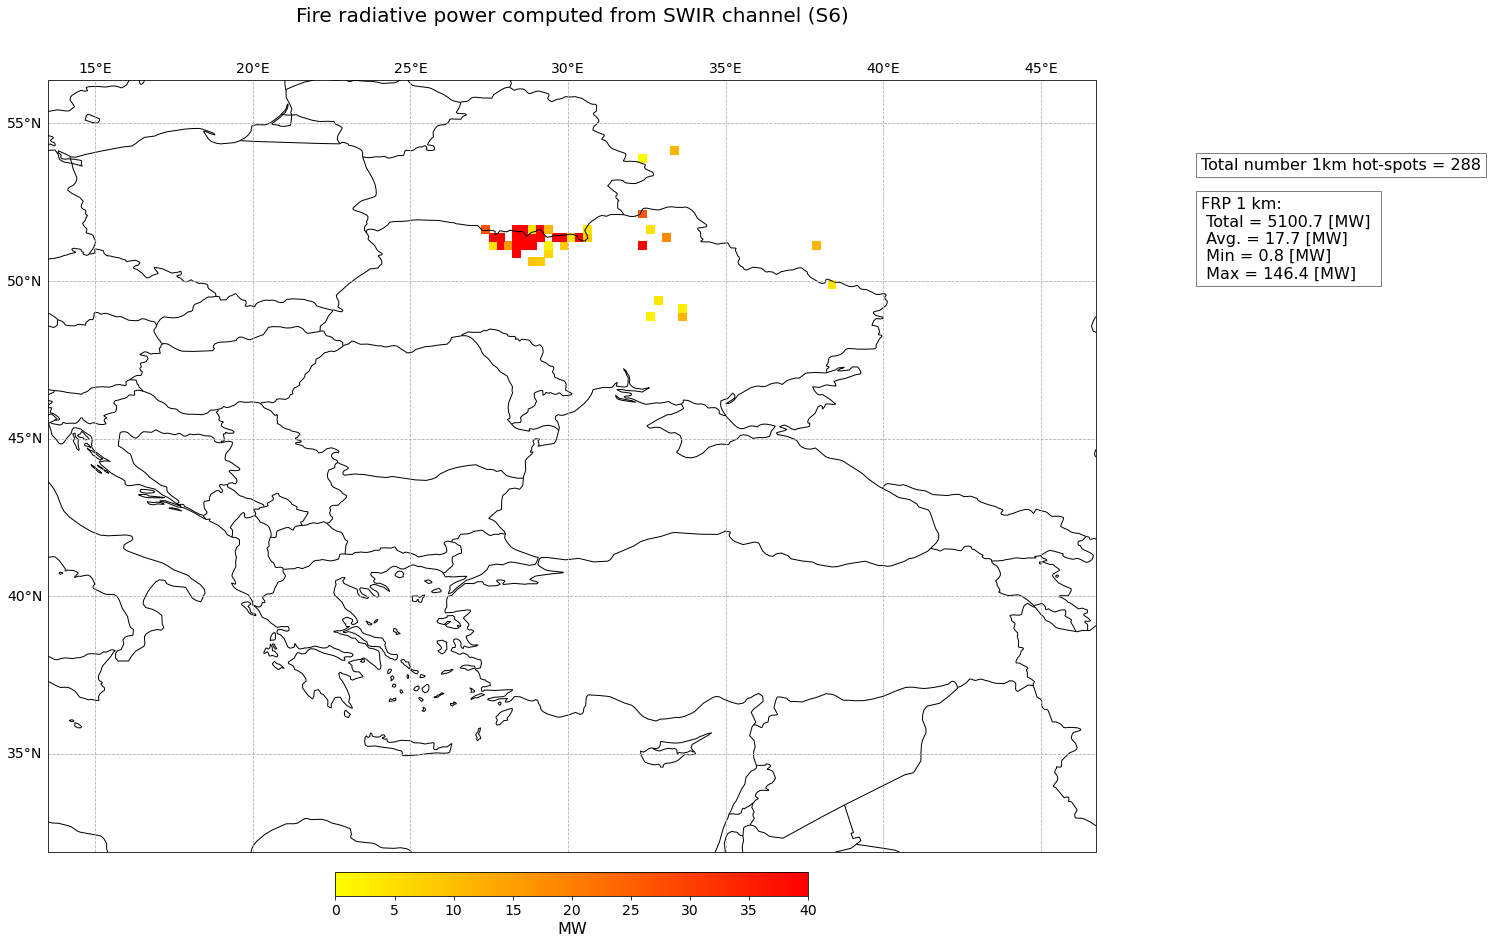

In [21]:
long_name = frp_swir.long_name
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_swir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name, 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<br>

Let us repeat the same processing steps for the `FRP computed from SWIR channel`, but with the SAA filter applied.

<br>

## <a id='load_swir_nosaa'></a> Load, mask and regrid `FRP computed from SWIR channel (2.25 um) with SAA filter applied`

Load the flag for the `South Atlantic Anomaly (SAA)` with the data variable name `FLAG_SWIR_SAA`. 

In [22]:
FLAG_FRP_SWIR_SAA_nc = frp_xr['FLAG_SWIR_SAA']
FLAG_FRP_SWIR_SAA_nc

<xarray.DataArray 'FLAG_SWIR_SAA' (fires: 917)>
array([-1, -1, -1, ..., -1, -1, -1], dtype=int16)
Dimensions without coordinates: fires
Attributes:
    long_name:      Flag South Atlantic Anomaly (SAA) suspected from SWIR cha...
    flag_values:    [-1  0  1  2  3  4]
    flag_meanings:  NA Unlikely Possible Spare Spare Spare

Create now the mask for only valid pixels of the `FRP SWIR` data (data values not equal to -1) and include the `FLAG_SWIR_SAA` (flag equals to 0) as additional information.

In a subsequent step, you can apply the mask with the function [generate_masked_array](../functions.ipynb#generate_masked_array). You see that 284 fires were detected under this category.

In [26]:
mask_frp_swir_nosaa = xr.where((frp_swir!=-1.) & (FLAG_FRP_SWIR_SAA_nc==0), 1, 0)
mask_frp_swir_nosaa

masked_frp_swir_nosaa = xr.where(mask_frp_swir_nosaa==1, frp_swir, np.nan)
masked_frp_swir_nosaa

masked_frp_swir_nosaa = generate_masked_array(xarray=frp_swir, 
                                              mask=mask_frp_swir_nosaa, 
                                              threshold=1, 
                                              operator='=', 
                                              drop=True)

masked_frp_swir_nosaa

<xarray.DataArray (fires: 284)>
array([ 14.49562811,   3.33291371,   2.14934458,   2.56304328,
         3.90616017,  25.01275899,   3.29803704,   2.18113198,
        10.08653529,   4.08239337,   4.14176581,  17.53911234,
        24.31956132,  39.66215248,  33.82620415,  30.35514323,
        16.5899628 ,  10.69805581,  16.46655874,   8.61558456,
        12.39634869,  15.37661605,   2.09217688,   5.39678422,
         9.31182407,   5.53583791,   4.73188584,   2.24392179,
         2.02795424,  10.90125825,  42.19268652,  78.43669098,
         5.26424931,   6.44829128,   4.02902254,   4.40256972,
       114.4474222 ,  14.36229928,   4.00833544,   2.1363703 ,
        63.64643835,  40.05282978,   4.82775712,   4.93608558,
         7.24567586,   9.50146626,   2.60117086,   4.69945244,
        22.84236851,   5.26941898,   3.54188678,   3.83032744,
        17.2442377 ,   5.01388154,   3.33508042,   3.35060416,
         3.05037712,  98.84662998,  28.48529574,  97.98744278,
        12.09501137,   6.53972056,  16.7393141 ,   5.95320505,
        96.66842125, 145.75499258,  85.90668195,  58.88739258,
        30.70970452,  12.04985274,   2.99779824, 146.44188578,
        36.4594933 ,  14.35096281,  21.78522798,  26.85353738,
        34.81490182,  18.12812372,  13.99992626,  91.22349634,
...
        31.38730627,   3.30029445,   4.80446191,  11.62447116,
        12.47087527,   2.78774938,  12.34110274,  14.70438707,
         9.69523975,  11.95392955,   2.62882864,   2.6944352 ,
         2.83754263,   3.84452064,   9.37167223,   2.5706428 ,
         4.11995493,  42.59326735,   7.20035676,   5.78504398,
         5.79775833,   4.92857802,   8.42913429,   2.28509322,
         2.19690111,   2.17780918,  10.21241492,  40.94081832,
         4.77733552,   4.88029332,   2.13564605,   2.91995814,
        12.86637011,  25.16388654,   3.08774416,   4.15847944,
        15.66028289,  60.99995361,  15.4219094 ,   3.44949106,
         3.54539624,  27.82770275,   7.11206998,   3.23168261,
        11.46899361,  36.99868431,   2.29013721,   4.42277682,
         2.28085854,   5.55289922,   2.25381566,  22.3870707 ,
        39.84480084,   2.06024876,   4.73529141,  19.61034024,
         3.29988249,   6.30838584,   3.64944583,   2.44370361,
        26.30880727,   9.21348207,   3.1587122 ,  20.1291376 ,
        30.39497223,   4.2724718 ,   3.83997233,  48.12237184,
         2.67097676,   2.44301919,   4.67715784,   4.64287519,
         3.57717673,   7.57797711,   6.78176743,   2.2826038 ,
         2.37895625,  21.47653022,   1.86501398,   4.55366927])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

Let us store the total number fires and also the category of `FRP SWIR` with the `SAA filter` applied as variables.

In [27]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR_NoSAA    = len(masked_frp_swir_nosaa.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR_NoSAA

(917, 284)

Apply the gridding function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding) to grid the filtered `FRP SWIR` data. You have to specify the keyword argument `flag` to provide the gridding process the loaded `xarray.DataArray` `FLAG_FRP_SWIR_SAA_nc`.

In [29]:
FRP_SWIR_NoSAA_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_swir, 
                                                             parameter='swir_nosaa', 
                                                             lat_min=lat_min, 
                                                             lat_max=lat_max, 
                                                             lon_min=lon_min, 
                                                             lon_max=lon_max, 
                                                             sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                             sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                             n_fire=n_fire_SWIR_NoSAA,
                                                             lat_frp=lat_frp,
                                                             lon_frp=lon_frp,
                                                             flag=FLAG_FRP_SWIR_SAA_nc)
FRP_SWIR_NoSAA_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[33.125, 33.125, 33.125, ..., 33.125, 33.125, 33.125],
        [33.375, 33.375, 33.375, ..., 33.375, 33.375, 33.375],
        [33.625, 33.625, 33.625, ..., 33.625, 33.625, 33.625],
        ...,
        [54.625, 54.625, 54.625, ..., 54.625, 54.625, 54.625],
        [54.875, 54.875, 54.875, ..., 54.875, 54.875, 54.875],
        [55.125, 55.125, 55.125, ..., 55.125, 55.125, 55.125]],
       dtype=float32),
 array([[15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625, 44.875, 45.125],
        [15.125, 15.375, 15.625, ..., 44.625

Mask out the invalid pixels for plotting.

In [30]:
mask_valid = np.where(FRP_SWIR_NoSAA_grid[:,:] != -9999., False, True)
D_swir_NoSAA          = np.ma.masked_array(FRP_SWIR_NoSAA_grid[:,:], mask=mask_valid)

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [31]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR_NoSAA)


FRP_sum      = np.sum(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir_nosaa.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'


Apply the function [visualize_s3_frp](../functions.ipynb#visualize_s3_frp) to visualize the data and make use of the data variable's attributes.

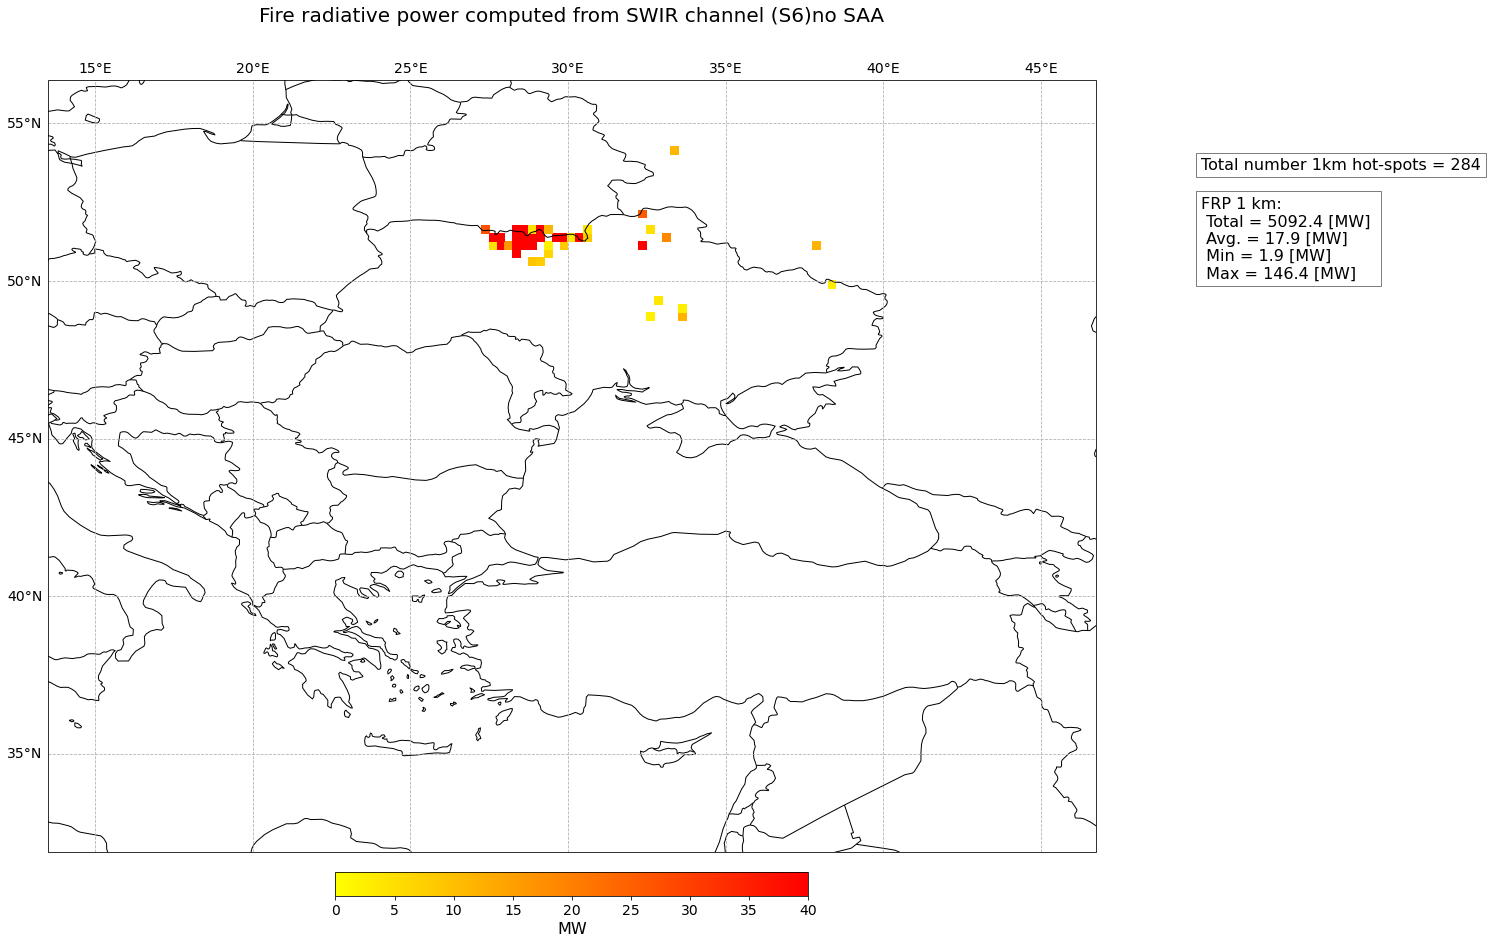

In [33]:
long_name = frp_swir.long_name
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_swir_NoSAA[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=long_name + 'no SAA', 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./322_Californian_fires_summer_2020_case_study.ipynb"><< 322 - Case study - Californian fires - Summer 2020</a><span style="float:right;"><a href="./332_Sentinel-3_SLSTR_NRT_FRP_Californian_fires_case_study.ipynb">332 - Case study - Sentinel-3 SLSTR NRT FRP - Californian fires >></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>